<hr style="height:3px; background-color:black; border:none;">

<hr style="height:3px; background-color:black; border:none;">

<h4 style="text-align:center;">
Image preprocessing-based ensemble deep learning classification of diabetic retinopathy
</h4>

###### Authors: Peter Macsik, Jarmila Pavlovicova, Slavomir Kajan, Jozef Goga, Veronika Kurilova
###### doi: https://doi.org/10.1049/ipr2.12987

<hr style="height:3px; background-color:black; border:none;">

Dataset Details
The main paper has considered two datasets of Diabetic Retinopathy images: APTOS 2019 Blindness Detection dataset and DDR dataset. For this assignment, **APTOS 2019 Blindness Detection** dataset is used. The dataset was organized by the Asia Pacific Tele-Ophthalmology Society (APTOS) and Aravind Eye Hospital for the competition **APTOS Blindness Detection by Kaggle**. This dataset consists of color fundus images which is fundus cameras under varying imaging conditions. The number of classes within these images are five which is assigned by the clinicians. These classes are:

1.	No DR 
2.	Mild 
3.	Moderate 
4.	Severe 
5.	Proliferative DR

Along with the images, the image-level DR grades provided by trained clinicians In the project the train–test split weightage is 80% training and 20% testing (Note: This is a stratified split). The major challenges associated with the APTOS dataset are, noises, some might be out of focus, and there could be inter class similarity between the images. Therefore, this dataset is very suitable for DR classification task.


In [1]:
# Path to save the checkpoints of the model
import os

CHECKPOINT_DIR = "/kaggle/working/APTOS_Checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Checkpoint directory:", CHECKPOINT_DIR)


Checkpoint directory: /kaggle/working/APTOS_Checkpoints


In [2]:
#To ignore the warnings
import warnings
warnings.filterwarnings("ignore")


# Xception Model

In [3]:
# Imports 
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint


2026-01-08 10:18:07.703964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767867487.725274     111 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767867487.731686     111 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:
# Dataset importing

# APTOS Kaggle path
APTOS_ROOT = "/kaggle/input/aptos2019-blindness-detection"

CSV_PATH = f"{APTOS_ROOT}/train.csv"
IMG_DIR  = f"{APTOS_ROOT}/train_images"

# Read CSV
df = pd.read_csv(CSV_PATH)

# Build image paths
df["img_path"] = df["id_code"].apply(
    lambda x: f"{IMG_DIR}/{x}.png"
)

all_imgs = df["img_path"].values
all_lbls = df["diagnosis"].values

# 80:20 stratified split (paper-aligned)
train_imgs, test_imgs, train_lbls, test_lbls = train_test_split(
    all_imgs,
    all_lbls,
    test_size=0.2,
    random_state=42,
    stratify=all_lbls
)

print("Training images:", len(train_imgs))
print("Testing images:", len(test_imgs))


Training images: 2929
Testing images: 733


In [5]:
# Returns the input image without any additional processing or enhancement
def original(img):
    return img

# This method enhances local contrast by subtracting a blurred version (min-pool–like effect)
def minpool(img):
    blur = cv2.GaussianBlur(img, (0,0), sigmaX=10)
    return cv2.addWeighted(img, 4, blur, -4, 128)

# Applying CLAHE independently on R, G, and B channels
def rgb_clahe(img):
    clahe = cv2.createCLAHE(2.0,(8,8))
    r,g,b = cv2.split(img)
    return cv2.merge([clahe.apply(r), clahe.apply(g), clahe.apply(b)])

# Applying CLAHE only on the luminance channel in the LAB color space
def lab_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(2.0,(8,8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2RGB)

# Enhancing the green channel using max intensity and CLAHE 
def maxgreen(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    green = img[:,:,1]
    maxpix = np.max(img, axis=2)
    clahe = cv2.createCLAHE(2.0,(8,8))
    return cv2.merge([
        clahe.apply(gray),
        clahe.apply(green),
        clahe.apply(maxpix)
    ])

In [6]:
# Mapping of  the preprocessing method names to their corresponding functions
preprocesses = {
    "original": original,
    "minpool": minpool,
    "rgb_clahe": rgb_clahe,
    "lab_clahe": lab_clahe,
    "maxgreen": maxgreen
}

In [7]:

class APTOSGenerator(Sequence):  # The custom Keras data generator for on-the-fly loading and preprocessing
    def __init__(self, imgs, labels, preprocess, batch=16):
        self.imgs = imgs   # List of image file paths
        self.labels = labels # Corresponding class labels
        self.preprocess = preprocess # Preprocessing function to apply
        self.batch = batch  # Batch size

    def __len__(self):
        return len(self.imgs) // self.batch # Number of batches per epoch

    def __getitem__(self, idx):
        X, y = [], [] # Containers for images and labels
        # Select batch image and label path
        batch_imgs = self.imgs[idx*self.batch:(idx+1)*self.batch] 
        batch_lbls = self.labels[idx*self.batch:(idx+1)*self.batch]

        for img_path, label in zip(batch_imgs, batch_lbls):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (299,299))
            img = self.preprocess(img)

           # Apply random horizontal flip for data augmentation(online as per paper)
            if np.random.rand() < 0.5:
                img = cv2.flip(img, 1)

            X.append(img/255.0) # Normalize image to [0,1]
            y.append(label) # Store label

        return np.array(X), tf.keras.utils.to_categorical(y, 5)  # Return batch and one-hot labels


### Architecture Design of Xception Model (Block Diagram)

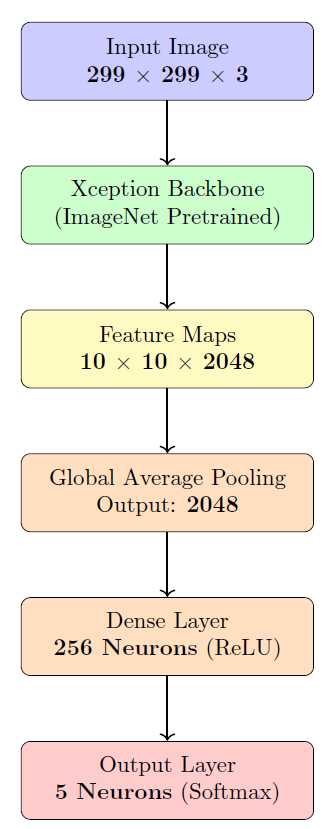

In [1]:
from IPython.display import Image, display
display(Image('Xception_image.png'))

#### Xception Transfer Learning Model for APTOS Classification

In [8]:
def build_xception():
    # Load Xception backbone without its original classifier
    base = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=(299,299,3)
    )
     # Freeze backbone weights to preserve pretrained features
    base.trainable = False
    # Custom classification head on top of the backbone
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation="relu")(x)
    out = Dense(5, activation="softmax")(x)

    # Constructing of the full model by connecting input to output
    model = Model(base.input, out)
    model.compile(
        optimizer=Nadam(0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [9]:
#Defining the checkpoints for saving for Xception models
def get_checkpoint(name):
    return ModelCheckpoint(
        filepath=os.path.join(CHECKPOINT_DIR, f"{name}.keras"),
        save_best_only=False,   # save EVERY epoch
        verbose=1
    )

In [11]:
# For ignoring warnings
import os
import warnings

# Silence TensorFlow logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0=all, 1=info, 2=warning, 3=error

# Disable XLA warnings
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

# Silence Python warnings
warnings.filterwarnings("ignore")


In [12]:
xception_models = []
EPOCHS = 10   # stable for Kaggle

for name, fn in preprocesses.items():
    print(f"\nTraining Xception with preprocessing: {name}")

# Initialize the data generator with selected preprocessing
    gen = APTOSGenerator(
        train_imgs,
        train_lbls,
        preprocess=fn,
        batch=16
    )
    
# Defining the checkpoint path for this preprocessing variant
    model_path = os.path.join(CHECKPOINT_DIR, f"xception_{name}.keras")

# Loading the  existing model if checkpoint exists, otherwise creating a new one
    if os.path.exists(model_path):
        print("Resuming from checkpoint")
        model = load_model(model_path)
    else:
        print("Starting new model")
        model = build_xception()
        
# Training the model and saving the best checkpoints
    
    model.fit(
        gen,
        epochs=EPOCHS,
        callbacks=[get_checkpoint(f"xception_{name}")]
    )

       # Storing of the trained model for comparison or ensembling

    xception_models.append(model)


Training Xception with preprocessing: original
Starting new model
Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6697 - loss: 0.8658
Epoch 1: saving model to /kaggle/working/APTOS_Checkpoints/xception_original.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.6700 - loss: 0.8651
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7790 - loss: 0.5774
Epoch 2: saving model to /kaggle/working/APTOS_Checkpoints/xception_original.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.7790 - loss: 0.5774
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8153 - loss: 0.4865
Epoch 3: saving model to /kaggle/working/APTOS_Checkpoints/xception_original.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.8153 - loss: 0.4867
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8384 - loss: 0.4382
Epoch 4: saving model to /kaggle/working/APTOS_Checkpoints/xception_original.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 288s

#### Importing the Xception models after session timeout for further analysis:

In [43]:
#Imports
import cv2
import numpy as np
import pandas as pd

from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

import matplotlib.pyplot as plt


In [44]:
# Loading the APTOS dataset paths and labels from CSV
APTOS_ROOT = "/kaggle/input/aptos2019-blindness-detection"
CSV_PATH = f"{APTOS_ROOT}/train.csv"
IMG_DIR  = f"{APTOS_ROOT}/train_images"

# Constructing full image file paths for training images
df = pd.read_csv(CSV_PATH)
df["img_path"] = df["id_code"].apply(lambda x: f"{IMG_DIR}/{x}.png")

# Extracting the image paths and corresponding diagnosis labels
imgs = df["img_path"].values
lbls = df["diagnosis"].values

# Creating a stratified 80–20 split to form a held-out test se
_, test_imgs, _, test_lbls = train_test_split(
    imgs, lbls, test_size=0.2, random_state=42, stratify=lbls
)

print("Test samples:", len(test_imgs))

Test samples: 733


In [45]:
#Redefining the preprocessing methods
def original(img):
    return img

def minpool(img):
    blur = cv2.GaussianBlur(img, (0,0), sigmaX=10)
    return cv2.addWeighted(img, 4, blur, -4, 128)

def rgb_clahe(img):
    clahe = cv2.createCLAHE(2.0,(8,8))
    r,g,b = cv2.split(img)
    return cv2.merge([clahe.apply(r), clahe.apply(g), clahe.apply(b)])

def lab_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(2.0,(8,8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l,a,b)), cv2.COLOR_LAB2RGB)

def maxgreen(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    green = img[:,:,1]
    maxpix = np.max(img, axis=2)
    clahe = cv2.createCLAHE(2.0,(8,8))
    return cv2.merge([
        clahe.apply(gray),
        clahe.apply(green),
        clahe.apply(maxpix)
    ])


In [46]:
preprocesses = {
    "original": original,
    "minpool": minpool,
    "rgb_clahe": rgb_clahe,
    "lab_clahe": lab_clahe,
    "maxgreen": maxgreen
}


In [50]:
#Loading the Xception models(saved and downloaded)
from tensorflow.keras.models import load_model
import os

XCEPTION_MODEL_DIR = "/kaggle/input/epochs/keras/default/1"


xception_files = {
    "original": "xception_original.keras",
    "minpool": "xception_minpool.keras",
    "rgb_clahe": "xception_rgb_clahe (1).keras",   
    "lab_clahe": "xception_lab_clahe.keras",
    "maxgreen": "xception_maxgreen.keras"
}

xception_models = {}

for name, filename in xception_files.items():
    path = os.path.join(XCEPTION_MODEL_DIR, filename)

    if not os.path.exists(path):
        print(f"File not found: {filename}")
        continue

    xception_models[name] = load_model(path, compile=False)
    print(f"Loaded Xception model: {filename}")


Loaded Xception model: xception_original.keras
Loaded Xception model: xception_minpool.keras
Loaded Xception model: xception_rgb_clahe (1).keras
Loaded Xception model: xception_lab_clahe.keras
Loaded Xception model: xception_maxgreen.keras


### Ensemble prediction

In [51]:
# Performing the ensemble prediction by averaging outputs from multiple Xception models
def ensemble_predict_xception(img_path):
    probs = []

    # Applies the corresponding preprocessing used during training for each model
    for name, model in xception_models.items():
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (299, 299))
        img = preprocesses[name](img)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        probs.append(model.predict(img, verbose=0))

    avg_prob = np.mean(probs, axis=0)
    # Returning the final class label based on highest averaged probability
    return np.argmax(avg_prob)

In [53]:
import os
import warnings

# Silence TensorFlow logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0=all, 1=info, 2=warning, 3=error

# Disabling XLA warnings
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

# Silence Python warnings
warnings.filterwarnings("ignore")


In [54]:
# Initialize containers for evaluation
y_true = []
y_pred = []

# Generate predictions on the test set
for img, label in zip(test_imgs, test_lbls):
    y_true.append(label)
    y_pred.append(ensemble_predict_xception(img))
# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


#### (vi) Performance Evaluation Measures 


In [55]:
acc = accuracy_score(y_true, y_pred)
ck  = cohen_kappa_score(y_true, y_pred)
cqk = cohen_kappa_score(y_true, y_pred, weights="quadratic")

print("\n===== XCEPTION ENSEMBLE RESULTS (APTOS) =====")
print(f"Accuracy (Acc): {acc:.4f}")
print(f"Cohen's Kappa (CK): {ck:.4f}")
print(f"Quadratic Weighted Kappa (CQK): {cqk:.4f}")



===== XCEPTION ENSEMBLE RESULTS (APTOS) =====
Accuracy (Acc): 0.8022
Cohen's Kappa (CK): 0.6925
Quadratic Weighted Kappa (CQK): 0.8510


<Figure size 600x600 with 0 Axes>

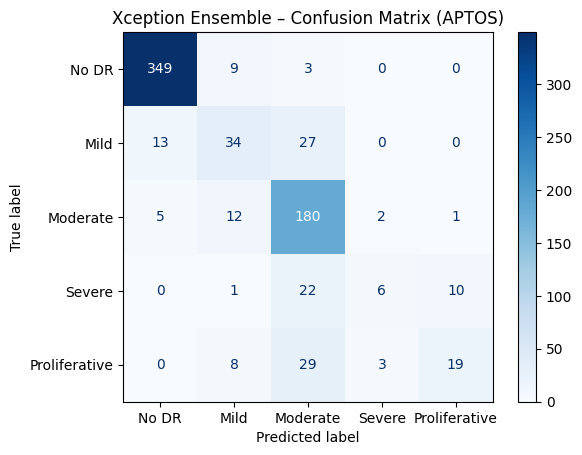

In [56]:
#Plotting Confusiuon Matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[
        "No DR", "Mild", "Moderate", "Severe", "Proliferative"
    ]
)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Xception Ensemble – Confusion Matrix (APTOS)")
plt.show()


#### Inferences:
- The confusion matrix shows a strong diagonal dominance, which means that there effective classification across most if the diabetic retinopathy stages.

- The model has very high accuracy for the No DR class, which denotes that there is reliable identification of healthy retinal images.

- Moderate DR is classified most consistently, indicating that it is a well-learned central disease stage.

- Misclassifications mainly occur between adjacent  severity levels, like the Mild–Moderate and Severe–Proliferative.

- Misclassifications are very low, which denotes a  clinically reasonable prediction behavior.

- Low performance in Severe and Proliferative classes can be related to class imbalance and the visual overlap.

- This matrix therefore suppports high quadratic weighted kappa score and confirms the robust overall classification performance.

- **The accuracy measures are close to one observed in the base paper**

# EfficientNetB4

In [30]:
#Imports
import os
import cv2
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence


In [31]:
#Checkpoints directory where checkpoints of the models get saved
CHECKPOINT_DIR = "/kaggle/working/APTOS_Checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print("Checkpoint dir:", CHECKPOINT_DIR)


Checkpoint dir: /kaggle/working/APTOS_Checkpoints


#### iii. Data Pre-processing
- As similar to Xception model

In [32]:
# Returns the original image without  any preprocessing
def original(img):
    return img
# Enhancing the local contrast by subtracting a heavily blurred version of the image 
def min_pooling(img):
    blur = cv2.GaussianBlur(img, (0, 0), sigmaX=10)
    return cv2.addWeighted(img, 4, blur, -4, 128)
#Applying the CLAHE independently to each RGB channel for improving local contrast
def rgb_clahe(img):
    out = np.zeros_like(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    for i in range(3):
        out[:, :, i] = clahe.apply(img[:, :, i])
    return out
#Applying the CLAHE only on the luminance channel in LAB color space for enhanced contrast
def lab_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(2.0, (8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
# Enhancing the retinal features using CLAHE on grayscale, green channel, and max-intensity channel
def maxgreen_clahe(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    green = img[:, :, 1]
    maxc = np.max(img, axis=2)

    clahe = cv2.createCLAHE(2.0, (8, 8))
    g1 = clahe.apply(gray)
    g2 = clahe.apply(green)
    g3 = clahe.apply(maxc)

    return np.stack([g1, g2, g3], axis=2)


In [33]:
# Dictionary mapping preprocessing method names to their functions defined above
preprocesses = {
    "original": original,
    "minpool": min_pooling,
    "rgb_clahe": rgb_clahe,
    "lab_clahe": lab_clahe,
    "maxgreen": maxgreen_clahe
}

In [35]:
# Input dataset path
import os
os.listdir("/kaggle/input")

['aptos2019-blindness-detection']

In [36]:
#Evaluating the files inside the dataset
os.listdir("/kaggle/input/aptos2019-blindness-detection")

['sample_submission.csv',
 'train_images',
 'train.csv',
 'test.csv',
 'test_images']

In [37]:
#Defining paths for training images and corresponding labelling file
BASE_DIR = "/kaggle/input/aptos2019-blindness-detection"
IMG_DIR = os.path.join(BASE_DIR, "train_images")
CSV_PATH = os.path.join(BASE_DIR, "train.csv")

In [38]:
#Reading the required files
import pandas as pd

df = pd.read_csv(CSV_PATH)

train_imgs = []
train_lbls = []

for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["id_code"] + ".png")
    if os.path.exists(img_path):
        train_imgs.append(img_path)
        train_lbls.append(row["diagnosis"])

print("Total images:", len(train_imgs))


Total images: 3662


In [39]:
#Customising the Keras data generator optimized for EfficientNet-based models on the APTOS dataset
class APTOSGeneratorEffNet(Sequence):
    #Initializing the dataset paths, labels, preprocessing method, and batching strategy
    def __init__(self, imgs, labels, preprocess, batch=8, shuffle=True):
        self.imgs = imgs
        self.labels = labels
        self.preprocess = preprocess
        self.batch = batch
        self.shuffle = shuffle
        self.indices = np.arange(len(self.imgs))
        self.on_epoch_end()

    def __len__(self): # Returning the number of batches per epoch
        return len(self.imgs) // self.batch
  # Shuffling the sample indices at the end of each epoch for improving the generalization
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
 # Loading a batch of images, applying the preprocessing and augmentation, and returning model-ready tensors
    def __getitem__(self, idx):
        X, y = [], []
        batch_ids = self.indices[idx*self.batch:(idx+1)*self.batch]

        for i in batch_ids:  
            img = cv2.imread(self.imgs[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (380, 380))

            img = self.preprocess(img)

           # Applying the random horizontal flip for online data augmentation as specified in paper
            if np.random.rand() < 0.5:
                img = cv2.flip(img, 1)

            #Normalizing
            img = img / 255.0
            X.append(img)
            y.append(self.labels[i])

        return np.array(X), tf.keras.utils.to_categorical(y, 5)


#### EfficientNetB4-based transfer learning model

#### Architecture Design of EfficientNetB4 Model (Block Diagram)

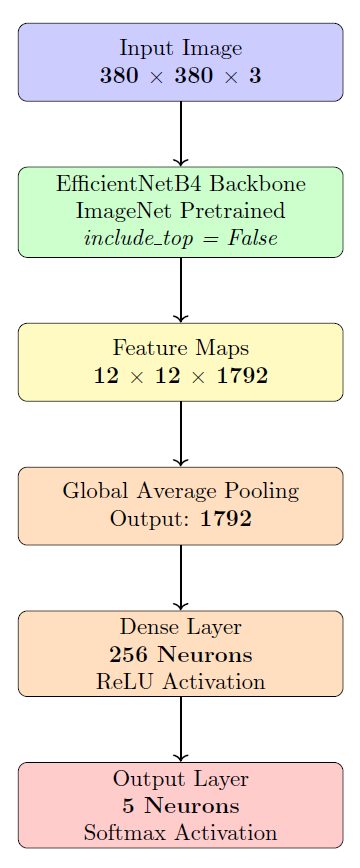

In [3]:
from IPython.display import Image, display
display(Image('Efficient Net _image.png'))

In [40]:
# Building the EfficientNetB4-based transfer learning model pretrained on ImageNet
def build_effnet():
    base = EfficientNetB4(
        weights="imagenet",
        include_top=False,
        input_shape=(380, 380, 3)
    )
    # Freezing the backbone and adding a custom classification head for APTOS grading
    base.trainable = False
    #Global average pooling to reduce overfitting and parameter count
    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation="relu")(x)
    out = Dense(5, activation="softmax")(x)
    #Compilng the model for 5-class categorical classification
    model = Model(base.input, out)
    model.compile(
        optimizer=Nadam(0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [41]:
#Defining the checkpoint for the model
def get_checkpoint(name):
    return ModelCheckpoint(
        filepath=os.path.join(CHECKPOINT_DIR, f"{name}.keras"),
        monitor="loss",
        save_best_only=False,
        verbose=1
    )

In [ ]:
effnet_models = []

for name, fn in preprocesses.items():
    print(f"\nTraining EfficientNet from scratch: {name}")

    # Initialize EfficientNet-specific data generator with selected preprocessing
    gen = APTOSGeneratorEffNet(
        train_imgs,
        train_lbls,
        preprocess=fn,
        batch=8
    )

    # Building the EfficientNetB4 model with the ImageNet-pretrained frozen backbone
    model = build_effnet()

    # Stage 1: Training only the classification head while keeping backbone frozen
    model.fit(
        gen,
        epochs=5,
        callbacks=[get_checkpoint(f"effnet_{name}")]
    )

    #Stage 2: Fine-tuning the top layers of the backbone for task-specific adaptation
    print("Fine-tuning EfficientNet")

    for layer in model.layers[-40:]:
        layer.trainable = True
    # Recompiling the model with a lower learning rate for stable fine-tuning
    model.compile(
        optimizer=Nadam(5e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    # Continuing the training with partially unfrozen backbone
    model.fit(
        gen,
        epochs=8,
        callbacks=[get_checkpoint(f"effnet_{name}")]
    )

    effnet_models.append(model)



Training EfficientNet from scratch: original
Epoch 1/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.4662 - loss: 1.3532
Epoch 1: saving model to /kaggle/working/APTOS_Checkpoints/effnet_original.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 392s 781ms/step - accuracy: 0.4663 - loss: 1.3531
Epoch 2/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.4971 - loss: 1.2950
Epoch 2: saving model to /kaggle/working/APTOS_Checkpoints/effnet_original.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 354s 774ms/step - accuracy: 0.4971 - loss: 1.2950
Epoch 3/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.5027 - loss: 1.2829
Epoch 3: saving model to /kaggle/working/APTOS_Checkpoints/effnet_original.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 354s 775ms/step - accuracy: 0.5027 - loss: 1.2830
Epoch 4/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.5067 - loss: 1.3019
Epoch 4: saving model to /kaggle/working/APTOS_Checkpoints/effnet_original.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 358s 784ms/step 

#### Inferences
- EfficientNetB4 shows significantly lower performance with original images, indicating that the model is very sensitive to preprocessing quality for the retinal image analysis.

- Among all the preprocessing methods, Minpool preprocessing is consistently outperforming others, with highest training accuracy (~68%) after the fine-tuning.

- Whereas the CLAHE-based methods (RGB and LAB) have moderate improvements after fine-tuning, but  performance is low compared to Minpool preprocessing.

- Fine-tuning the top layers of EfficientNet led to  stable accuracy improvements, which indicates the effectiveness of the two-stage training strategy here.

- But even with fine-tuning, EfficientNet **couldn't reach the performance level** of the Xception models, which suggests that EfficientNetB4 **may require stronger regularization, class balancing,  longer training hours, high compuational power(as mentioned in the base paper) for this task**.

- Accuracy improvements decreased early stage for most preprocessing methods, indicating the limited gains from the extended training. 

- The higher loss values and slower convergence suggest in EfficientNet is very challenging to optimize on the APTOS dataset when compared to Xception.

- Overall performance remains low compared to Xception-based models on the APTOS dataset.

#### Reloading the models for getting ensembling and evaluation metrics since session time- out happened

In [5]:
import os

print("Datasets attached:")
print(os.listdir("/kaggle/input"))


Datasets attached:
['epochs', 'aptos2019-blindness-detection']


In [12]:
#Evaluating what all models are saved into input
MODEL_DIR = "/kaggle/input/epochs/keras/default/1"  
print(os.listdir(MODEL_DIR))


['xception_maxgreen.keras', 'effnet_minpool.keras', 'xception_rgb_clahe (1).keras', 'effnet_rgb_clahe.keras', 'effnet_original.keras', 'xception_minpool.keras', 'xception_original.keras', 'xception_lab_clahe.keras']


In [13]:
# Imports
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [15]:
#Defining paths for training, testing sets and labelling files
APTOS_ROOT = "/kaggle/input/aptos2019-blindness-detection"
CSV_PATH = f"{APTOS_ROOT}/train.csv"
IMG_DIR  = f"{APTOS_ROOT}/train_images"

df = pd.read_csv(CSV_PATH)
df["img_path"] = df["id_code"].apply(lambda x: f"{IMG_DIR}/{x}.png")

imgs = df["img_path"].values
lbls = df["diagnosis"].values

_, test_imgs, _, test_lbls = train_test_split(
    imgs, lbls, test_size=0.2, random_state=42, stratify=lbls
)

print("Test images:", len(test_imgs))


Test images: 733


In [16]:
# Deining the earlier models which we implemented
def original(img):
    return img

def minpool(img):
    blur = cv2.GaussianBlur(img, (0,0), sigmaX=10)
    return cv2.addWeighted(img, 4, blur, -4, 128)

def rgb_clahe(img):
    clahe = cv2.createCLAHE(2.0,(8,8))
    r,g,b = cv2.split(img)
    return cv2.merge([clahe.apply(r), clahe.apply(g), clahe.apply(b)])


In [17]:
# Calling the functions
preprocesses = {
    "original": original,
    "minpool": minpool,
    "rgb_clahe": rgb_clahe
}

In [19]:
#Loading previous models for evaluating and ensembling
effnet_models = {}

for name in preprocesses.keys():
    path = f"{MODEL_DIR}/effnet_{name}.keras"
    effnet_models[name] = load_model(path, compile=False)
    print(f"Loaded EfficientNet: {name}")

Loaded EfficientNet: original
Loaded EfficientNet: minpool
Loaded EfficientNet: rgb_clahe


In [20]:
# Imports
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence

In [21]:
# Checkpoints for saving the checkpoints
CHECKPOINT_DIR = "/kaggle/working/APTOS_Checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


In [22]:
# Defining the paths for training, testing
APTOS_ROOT = "/kaggle/input/aptos2019-blindness-detection"
CSV_PATH = f"{APTOS_ROOT}/train.csv"
IMG_DIR = f"{APTOS_ROOT}/train_images"

df = pd.read_csv(CSV_PATH)

train_imgs = []
train_lbls = []

for _, row in df.iterrows():
    path = f"{IMG_DIR}/{row['id_code']}.png"
    if os.path.exists(path):
        train_imgs.append(path)
        train_lbls.append(row["diagnosis"])

print("Training images:", len(train_imgs))


Training images: 3662


In [23]:
#Defining functions for lab_clahe,maxgreen_clahe
def lab_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(2.0, (8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
def maxgreen_clahe(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    green = img[:, :, 1]
    maxc = np.max(img, axis=2)

    clahe = cv2.createCLAHE(2.0, (8, 8))
    g1 = clahe.apply(gray)
    g2 = clahe.apply(green)
    g3 = clahe.apply(maxc)

    return np.stack([g1, g2, g3], axis=2)


In [24]:
#APTOSGenerator as previously defined
class APTOSGeneratorEffNet(Sequence):
    def __init__(self, imgs, labels, preprocess, batch=8):
        self.imgs = imgs
        self.labels = labels
        self.preprocess = preprocess
        self.batch = batch

    def __len__(self):
        return len(self.imgs) // self.batch

    def __getitem__(self, idx):
        X, y = [], []
        batch_imgs = self.imgs[idx*self.batch:(idx+1)*self.batch]
        batch_lbls = self.labels[idx*self.batch:(idx+1)*self.batch]

        for img_path, label in zip(batch_imgs, batch_lbls):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (380, 380))
            img = self.preprocess(img)

            if np.random.rand() < 0.5:
                img = cv2.flip(img, 1)

            X.append(img / 255.0)
            y.append(label)

        return np.array(X), tf.keras.utils.to_categorical(y, 5)


In [25]:
#Building the EfficientNetB4 architecture as previously
def build_effnet():
    base = EfficientNetB4(
        weights="imagenet",
        include_top=False,
        input_shape=(380, 380, 3)
    )
    base.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(256, activation="relu")(x)
    out = Dense(5, activation="softmax")(x)

    model = Model(base.input, out)
    model.compile(
        optimizer=Nadam(0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [27]:
import os
import warnings

# Silence TensorFlow logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0=all, 1=info, 2=warning, 3=error

# Disable XLA warnings
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"

# Silence Python warnings
warnings.filterwarnings("ignore")


In [28]:
#Separate calling for lab_clahe
name = "lab_clahe"

gen = APTOSGeneratorEffNet(
    train_imgs,
    train_lbls,
    lab_clahe,
    batch=8
)

model = build_effnet()

checkpoint = ModelCheckpoint(
    filepath=f"/kaggle/working/APTOS_Checkpoints/effnet_{name}.keras",
    save_best_only=False,
    verbose=1
)

model.fit(
    gen,
    epochs=5,   # KEEP SMALL
    callbacks=[checkpoint]
)


Epoch 1/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.4740 - loss: 1.3360
Epoch 1: saving model to /kaggle/working/APTOS_Checkpoints/effnet_lab_clahe.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 485s 966ms/step - accuracy: 0.4741 - loss: 1.3360
Epoch 2/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.4967 - loss: 1.2966
Epoch 2: saving model to /kaggle/working/APTOS_Checkpoints/effnet_lab_clahe.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 390s 854ms/step - accuracy: 0.4967 - loss: 1.2966
Epoch 3/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.4986 - loss: 1.2927
Epoch 3: saving model to /kaggle/working/APTOS_Checkpoints/effnet_lab_clahe.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 390s 854ms/step - accuracy: 0.4986 - loss: 1.2927
Epoch 4/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.4930 - loss: 1.2946
Epoch 4: saving model to /kaggle/working/APTOS_Checkpoints/effnet_lab_clahe.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 392s 858ms/step - accuracy: 0.4930 - loss: 1.2946
Epoch 5/

In [29]:
# Separate calling for maxgreen
name = "maxgreen"

gen = APTOSGeneratorEffNet(
    train_imgs,
    train_lbls,
    maxgreen_clahe,
    batch=8
)

model = build_effnet()

checkpoint = ModelCheckpoint(
    filepath=f"/kaggle/working/APTOS_Checkpoints/effnet_{name}.keras",
    save_best_only=False,
    verbose=1
)

model.fit(
    gen,
    epochs=5,
    callbacks=[checkpoint]
)


Epoch 1/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.5038 - loss: 1.3266
Epoch 1: saving model to /kaggle/working/APTOS_Checkpoints/effnet_maxgreen.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 458s 904ms/step - accuracy: 0.5038 - loss: 1.3266
Epoch 2/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.4934 - loss: 1.2968
Epoch 2: saving model to /kaggle/working/APTOS_Checkpoints/effnet_maxgreen.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 411s 900ms/step - accuracy: 0.4934 - loss: 1.2968
Epoch 3/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.5087 - loss: 1.2889
Epoch 3: saving model to /kaggle/working/APTOS_Checkpoints/effnet_maxgreen.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 414s 906ms/step - accuracy: 0.5086 - loss: 1.2889
Epoch 4/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.5012 - loss: 1.2990
Epoch 4: saving model to /kaggle/working/APTOS_Checkpoints/effnet_maxgreen.keras
457/457 ━━━━━━━━━━━━━━━━━━━━ 414s 906ms/step - accuracy: 0.5011 - loss: 1.2990
Epoch 5/5
45

# Inferences:
- Both the LAB-CLAHE and MaxGreen preprocessing methods with EfficientNetB4 have limited learning capacity in the frozen-backbone stage, where the accuracy plateauing is around 49–51%.

- There is a small improvement across the epochs and relatively a very high loss value indicate that the feature representations from the pretrained backbone are not much aligned with the major retinal image characteristics under these methods.

- LAB-CLAHE and MaxGreen are less effective for EfficientNet when we compared to Minpool preprocessing, therefore EfficientNet is more sensitive to contrast normalization strategies.

### (v) Parameters and Hyperparameters(Xception and EfficientNetB4)
#### Parameters of the model:
##### Architectures used:
- Xception (ImageNet pretrained)
- EfficientNetB4 (ImageNet pretrained)

##### Trainable layers:
- Initial training was done by freezing the backbone 
- Fine-tuning was done for last 40 layers of EfficientNetB4 which were unfrozen and here the full Xception head is trained

##### Classification head:
- Global Average Pooling(GAP)
- Dense layer: Fully connected layer with 256 neurons (ReLU activation)
- Classifier: Output layer with 5 neurons (Softmax) corresponding to the already defined ICDRSS classes

##### Loss function used: Categorical Cross-Entropy


#### Hyperparameters:
##### Input image size for architectures:
  
  - Xception: 299 × 299
  
  - EfficientNetB4: 380 × 380
  
##### Data augmentation: Online random horizontal flipping with a probability of 0

##### Optimizer used : Nadam

##### Learning rate for architectures:

  
  - Xception: 0.001

  
  - EfficientNetB4:
    - Frozen stage: 0.001
    - Fine-tuning stage: 5 × 10⁻⁵

##### Batch size in both architectures:
    - Xception: 16
    - EfficientNetB4: 8

##### Number of epochs:
   - Xception: 10 epochs per preprocessing variant

##### EfficientNetB4:
   - 5 epochs (frozen backbone)
   - 8 epochs (fine-tuning)


In [30]:
#Imports for evaluation metrics
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score

In [31]:
#Ensembling as similar to Xception
def ensemble_predict_soft(img_path, models, preprocesses):
    probs = []

    for name, model in models.items():
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (380, 380))
        img = preprocesses[name](img)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        probs.append(model.predict(img, verbose=0))

    avg_prob = np.mean(probs, axis=0)
    return np.argmax(avg_prob)


In [33]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_enable_latency_hiding_scheduler=false"


In [34]:
y_true = []
y_pred = []

# Ensemble inference on the test set using EfficientNet models
for img_path, label in zip(test_imgs, test_lbls):
    pred = ensemble_predict_soft(img_path, effnet_models, preprocesses)
    y_true.append(label)
    y_pred.append(pred)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

#### Performance Evaluation Measures:

In [35]:
acc = accuracy_score(y_true, y_pred)
print("Ensemble Accuracy (Acc):", acc)


Ensemble Accuracy (Acc): 0.694406548431105


In [36]:
ck = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa (CK):", ck)


Cohen's Kappa (CK): 0.4876892787049951


In [37]:
cqk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
print("Cohen's Quadratic Weighted Kappa (CQK):", cqk)


Cohen's Quadratic Weighted Kappa (CQK): 0.5941999178680211


In [38]:
print("\n===== EfficientNet Ensemble Results (APTOS) =====")
print(f"Accuracy (Acc): {acc:.4f}")
print(f"Cohen's Kappa (CK): {ck:.4f}")
print(f"Quadratic Weighted Kappa (CQK): {cqk:.4f}")



===== EfficientNet Ensemble Results (APTOS) =====
Accuracy (Acc): 0.6944
Cohen's Kappa (CK): 0.4877
Quadratic Weighted Kappa (CQK): 0.5942


#### Inferences:
- The EfficientNet ensemble has an overall accuracy of ~69.4%, which indicates moderate classification performance on the APTOS test set.

- A Cohen’s Kappa of ~0.49 indicates there is only fair-to-moderate agreement beyond chance, that highlights difficulty in consistently predicting the exact disease grades.

- The quadratic weighted kappa (~0.59) is slightly higher than raw kappa, which denotes that most of the misclassifications occur between the adjacent severity levels than extreme classes.

- Compared to the Xception ensemble, EfficientNet has lower generalization capability, which means  architecture sensitivity to dataset characteristics.

- The results indicate that EfficientNet benefits from ensembling but still is limited by the weaker single-model representations(not so efficient).

- The  lower kappa scores suggest challenges in capturing fine-grained relationships among the diabetic retinopathy stages.

- EfficientNet ensemble even though acceptable, it does not have good performance for severity grading when compared to other architectures(Inference from this experiment; not from original paper.

- There are variations in accuracy compared to original which indicates that the limitations has to be taken care of in future and need longer running hours and various parameters.

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [41]:
cm = confusion_matrix(y_true, y_pred)

<Figure size 600x600 with 0 Axes>

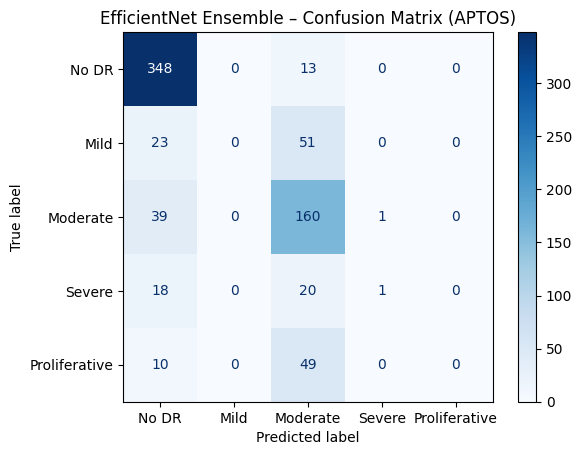

In [42]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[
        "No DR", "Mild", "Moderate", "Severe", "Proliferative"
    ]
)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("EfficientNet Ensemble – Confusion Matrix (APTOS)")
plt.show()

#### Inferences:
- The model strongly works on the Moderate class, which leads to the frequent misclassification of the Mild, Severe, and Proliferative cases as Moderate.

- Here no DR cases are classified perfectly, but Mild cases are almost never correctly identified, that indicates the poor separation of the early disease stages.

- Proliferative DR  is also not classified accurately which highlights severe class imbalance and non-reliability of model for advanced disease features.

# References:
[1] P. Macsik, J. Pavlovicova, S. Kajan, J. Goga, and V. Kurilova, “Image preprocessing-based ensemble deep learning classification of diabetic retinopathy,” IET Image Processing, vol. 17, no. 14, pp. 4300–4315, Nov. 2023, doi: 10.1049/ipr2.12987.

[2] P. Vashist, S. Singh, N. Gupta, and R. Saxena, “Role of early screening for diabetic retinopathy in patients with diabetes mellitus: An overview,” Indian Journal of Community Medicine, vol. 36, no. 4, pp. 247–252, 2011, doi: 10.4103/0970-0218.91324.

[3] G. Infeng, S. Qummar, Z. Junming, Y. Ruxian, and F. G. Khan, “Ensemble framework of deep CNNs for diabetic retinopathy detection,” Computational Intelligence and Neuroscience, vol. 2020, Article ID 8864698, 2020, doi: 10.1155/2020/8864698.

